<a href="https://colab.research.google.com/github/sebac820/tarea-1-recsys/blob/main/Tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1

## Librerías

In [117]:
import matplotlib.pyplot as plt
import pandas as pd

## Actividad 1: Análisis exploratorio

Importamos y visualizamos los datos de entrenamiento:

In [118]:
train_set = pd.read_csv('transactions_train.csv', header=0, index_col=0)
print(f'El dataset de entrenamiento cuenta con {train_set.shape[0]} filas y {train_set.shape[1]} columnas.')
print('Las primeras cinco filas son:')
train_set.head()

El dataset de entrenamiento cuenta con 1318501 filas y 5 columnas.
Las primeras cinco filas son:


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001,0.025407,2
1,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,537688014,0.050831,2
2,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,698877002,0.042356,2
3,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,382127027,0.032186,2
4,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,610776001,0.008458,2


### Número de compras por usuario

Obtenemos a los 10 usuarios más activos en el dataset:

In [119]:
# Hacemos una copia del set de entrenamiento manteniendo solamente la columna 'customer_id':
numero_de_compras_por_usuario = train_set.drop(columns=['t_dat', 'article_id', 'price', 'sales_channel_id'])
# Agregamos una columna 'numero_de_compras':
numero_de_compras_por_usuario['numero_de_compras'] = 1
# Agrupamos por 'customer_id' y contamos la cantidad de veces que se repite cada usuario en el set:
numero_de_compras_por_usuario = numero_de_compras_por_usuario.groupby('customer_id').count()
# Ordenamos la cuenta de cada usuario de mayor a menor:
numero_de_compras_por_usuario = numero_de_compras_por_usuario.sort_values(by='numero_de_compras', ascending=False)
# Calculamos el porcentaje que representa cada número de compras dentro del dataset:
numero_de_compras_por_usuario['porcentaje_del_dataset'] = numero_de_compras_por_usuario / train_set.shape[0] * 100
# Desplegamos el top 10 de usuarios más activos en el set:
display(numero_de_compras_por_usuario.head(10))
# Desplegamos el porcentaje total que representa el top 10 dentro del dataset:
porcentaje_total_que_representa_el_top_10 = numero_de_compras_por_usuario.iloc[0:10].sum()['porcentaje_del_dataset']
print(f'Porcentaje total que representa el top 10 dentro del dataset: {porcentaje_total_que_representa_el_top_10}%')


,numero_de_compras,porcentaje_del_dataset
customer_id,,
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc,1346,0.102086
84c34f4f564db1f437943c77af41f83bf6fd7c01701cbb050070369176905712,950,0.072052
e55d5ddb3a0c3fb1b4df8edbf526ba12989ab2a852c72774e3f3338cbbb3335e,910,0.069018
2df54f0d0653811fe06479c93905f3e6ecc6d07edf39d8b56e5b66c86182bedf,875,0.066363
9f12a01e2982f70a820b5dd61528bf769b94c5c5e43b23704f1f654784bcda58,789,0.059841
bbebb44478948f5052c3f4c5dc04f08653e7938886a85685917fd22b92f22cd0,740,0.056124
d3b5f70ec21ad1718cf4951445e97007de0d4e85c39ea9fd2fedaf1966280943,724,0.054911
ad3090d52d11671ffb43bfaa85e3620eff669e8c92c9114ba7755876254cbba8,670,0.050815
0152d53f51444891ea07013fd1fb8325415bb09bb6798a59359b21a8326d801b,664,0.050360


Porcentaje total que representa el top 10 dentro del dataset: 0.6309437763035446%


Así, el top 10 de usuarios con más actividad en el dataset se lleva el 0.6% de las compras, reportando más de 600 compras cada uno. Sin embargo, el resto de usuarios ha realizado una cantidad mucho menor de compras:

(array([69.,  8.,  8.,  8.,  0.,  0.,  0.,  0.,  1.,  5.]),
 array([  48. ,  348.4,  648.8,  949.2, 1249.6, 1550. , 1850.4, 2150.8,
        2451.2, 2751.6, 3052. ]),
 <BarContainer object of 10 artists>)

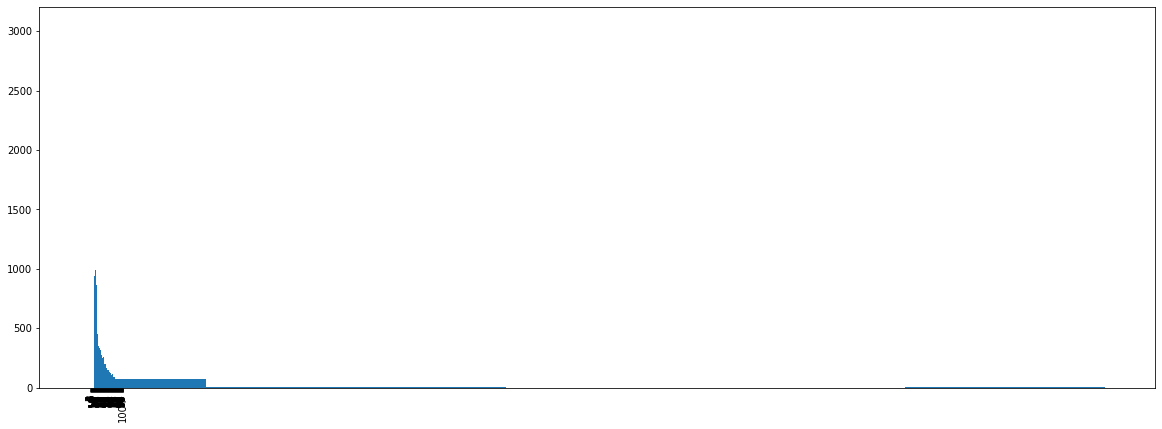

In [160]:
# Hacemos una copia del número de compras por usuario:
numero_de_usuarios_por_numero_de_compras = numero_de_compras_por_usuario.drop(columns=['porcentaje_del_dataset'])
# Agregamos una columna 'numero_de_usuarios'
numero_de_usuarios_por_numero_de_compras['numero_de_usuarios'] = 1
# Agrupamos por el número de compras, y contamos cuántos usuarios realizaron ese número de compras:
numero_de_usuarios_por_numero_de_compras = numero_de_usuarios_por_numero_de_compras.groupby('numero_de_compras').sum()
# Definimos un grupo que represente N o más compras:
N = 100
numero_de_usuarios_que_realizaron_N_o_mas_compras = numero_de_usuarios_por_numero_de_compras.loc[N:]['numero_de_usuarios'].sum()
numero_de_usuarios_por_numero_de_compras = numero_de_usuarios_por_numero_de_compras.loc[0:N-1]
numero_de_usuarios_por_numero_de_compras.loc[f'{N}+'] = numero_de_usuarios_que_realizaron_N_o_mas_compras
# Graficamos:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=90)
plt.bar(
    x=[i for i in range(len(numero_de_usuarios_por_numero_de_compras))],
    height=[numero_de_usuarios for numero_de_usuarios in numero_de_usuarios_por_numero_de_compras['numero_de_usuarios']],
    tick_label=numero_de_usuarios_por_numero_de_compras.index,
)

Notamos que en la distribución obtenida, la mayor parte de los usuarios han realizado solamente entre 2 a 22 compras, 